# Extended SF Quantum GAN Training with Comprehensive Monitoring

This notebook demonstrates extended training of the minimal SF quantum GAN with:
- **Extended Training**: 100+ epochs for proper convergence
- **Quality Tracking**: Real-time monitoring of generation quality
- **Comprehensive Visualization**: Training evolution dashboard
- **Performance Analysis**: Detailed convergence analysis

Based on the minimal results showing poor quality (Mean diff: 2.8244), we need much longer training.


## 1. Setup and Enhanced Imports


In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
import time
from scipy.stats import wasserstein_distance

# Configure matplotlib for Jupyter
%matplotlib inline
plt.style.use('default')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

# Import our clean training utilities
from utils.warning_suppression import enable_clean_training
from utils.quantum_losses import QuantumWassersteinLoss, QuantumMMDLoss


# Enable clean output
enable_clean_training()

print("Extended training environment setup complete ✓")
print(f"TensorFlow version: {tf.__version__}")


Clean training environment initialized
Warnings suppressed, ready for quantum training
Extended training environment setup complete ✓
TensorFlow version: 2.18.0


## 2. Import Quantum Components and Create Enhanced Trainer


In [2]:
# Import our SF-based quantum components
from models.generators.quantum_sf_generator import QuantumSFGenerator
from models.discriminators.quantum_sf_discriminator import QuantumSFDiscriminator
from training.qgan_sf_trainer import QGANSFTrainer

print("Quantum components imported successfully ✓")

# ===== QUANTUM WASSERSTEIN LOSS =====
class QuantumWassersteinLoss:
    def __init__(self, lambda_gp=10.0, lambda_entropy=0.5, lambda_physics=1.0):
        self.lambda_gp = lambda_gp
        self.lambda_entropy = lambda_entropy  
        self.lambda_physics = lambda_physics
    
    def __call__(self, real_samples, fake_samples, generator, discriminator):
        batch_size = tf.shape(real_samples)[0]
        
        # 1. Wasserstein distance
        real_output = discriminator.discriminate(real_samples)
        fake_output = discriminator.discriminate(fake_samples)
        w_distance = tf.reduce_mean(real_output) - tf.reduce_mean(fake_output)
        
        # 2. Gradient penalty
        alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
        interpolated = alpha * real_samples + (1 - alpha) * fake_samples
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            interp_output = discriminator.discriminate(interpolated)
        
        gradients = gp_tape.gradient(interp_output, interpolated)
        gradient_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
        gradient_penalty = self.lambda_gp * tf.reduce_mean(tf.square(gradient_norm - 1.0))
        
        # 3. Quantum regularization
        quantum_metrics = generator.compute_quantum_cost()
        
        # Entropy regularization (encourages diverse quantum states for different clusters)
        entropy_bonus = self.lambda_entropy * quantum_metrics['entropy']
        
        # Physics constraints (ensure valid quantum states)
        trace_penalty = self.lambda_physics * tf.square(quantum_metrics['trace'] - 1.0)
        norm_penalty = self.lambda_physics * tf.square(quantum_metrics['norm'] - 1.0)
        
        # Final losses
        d_loss = -w_distance + gradient_penalty + trace_penalty + norm_penalty
        g_loss = -tf.reduce_mean(fake_output) - entropy_bonus + trace_penalty + norm_penalty
        
        metrics = {
            'w_distance': w_distance,
            'gradient_penalty': gradient_penalty,
            'entropy': quantum_metrics['entropy'],
            'trace_error': tf.abs(quantum_metrics['trace'] - 1.0),
            'norm_error': tf.abs(quantum_metrics['norm'] - 1.0)
        }
        
        return d_loss, g_loss, metrics

# ===== STATIC DIMENSIONAL ADAPTER =====
class StaticDimensionalAdapter:
    def __init__(self, input_dim, output_dim, method='linear', seed=42):
        """
        Static adapter - NO trainable parameters!
        
        Args:
            input_dim: Input dimension
            output_dim: Output dimension  
            method: 'linear', 'pad_zero', 'truncate', 'repeat'
            seed: For reproducible random projections
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.method = method
        
        np.random.seed(seed)
        
        if method == 'linear' and input_dim != output_dim:
            # Fixed random projection matrix (Xavier initialization)
            self.projection_matrix = tf.constant(
                np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / (input_dim + output_dim)),
                dtype=tf.float32
            )
        else:
            self.projection_matrix = None
    
    def __call__(self, x):
        """Apply static transformation - NO gradients computed here!"""
        if self.method == 'linear' and self.projection_matrix is not None:
            return tf.matmul(x, self.projection_matrix)
        elif self.method == 'pad_zero':
            if self.output_dim > self.input_dim:
                padding = [[0, 0], [0, self.output_dim - self.input_dim]]
                return tf.pad(x, padding, mode='CONSTANT', constant_values=0)
            else:
                return x[:, :self.output_dim]
        elif self.method == 'truncate':
            return x[:, :self.output_dim]
        elif self.method == 'repeat':
            if self.output_dim > self.input_dim:
                repeats = self.output_dim // self.input_dim
                remainder = self.output_dim % self.input_dim
                repeated = tf.tile(x, [1, repeats])
                if remainder > 0:
                    repeated = tf.concat([repeated, x[:, :remainder]], axis=1)
                return repeated
            else:
                return x[:, :self.output_dim]
        else:
            return x  # Identity

# ===== ADAPTED QUANTUM MODELS =====
class AdaptedQuantumGenerator:
    def __init__(self, quantum_generator, adapter):
        self.quantum_gen = quantum_generator
        self.adapter = adapter  # Static, no gradients!
    
    def generate(self, z):
        quantum_output = self.quantum_gen.generate(z)  # Shape: [batch, m modes]
        adapted_output = self.adapter(quantum_output)  # Shape: [batch, 2]
        return adapted_output
    
    def compute_quantum_cost(self, target_state=None):
        """Expose the quantum generator's compute_quantum_cost method."""
        return self.quantum_gen.compute_quantum_cost(target_state)
    
    @property
    def trainable_variables(self):
        return self.quantum_gen.trainable_variables  # Only quantum gradients!
    
    @property
    def eng(self):
        return self.quantum_gen.eng

class AdaptedQuantumDiscriminator:
    def __init__(self, quantum_discriminator, adapter):
        self.quantum_disc = quantum_discriminator
        self.adapter = adapter  # Static, no gradients!
    
    def discriminate(self, x):
        adapted_input = self.adapter(x)  # Shape: [batch, 2] → [batch, m modes]
        return self.quantum_disc.discriminate(adapted_input)
    
    def compute_quantum_metrics(self):
        """Expose the quantum discriminator's compute_quantum_metrics method."""
        return self.quantum_disc.compute_quantum_metrics()
    
    @property
    def trainable_variables(self):
        return self.quantum_disc.trainable_variables  # Only quantum gradients!
    
    @property
    def eng(self):
        return self.quantum_disc.eng

print("Static dimensional adapter system created ✓")

# ===== ENHANCED TRAINING CONFIGURATION =====
class ExtendedQGANTrainer(QGANSFTrainer):
    """
    Enhanced trainer with quality monitoring during training using Quantum Wasserstein Loss.
    """
    
    def __init__(self, generator, discriminator, latent_dim=4, loss_type='quantum_wasserstein', **kwargs):
        # Initialize with your enhanced trainer
        super().__init__(generator, discriminator, latent_dim, loss_type=loss_type, **kwargs)
        
        self.quality_history = {
            'epochs': [],
            'mean_differences': [],
            'std_differences': [],
            'wasserstein_distances': [],
            'generator_losses': [],
            'discriminator_losses': [],
            'stability_metrics': [],
            'training_times': [],
            'quantum_metrics': []  # New: track quantum metrics
        }
    
    def compute_quality_metrics(self, real_data, n_samples=200):
        """Compute comprehensive quality metrics."""
        # Generate samples
        z = tf.random.normal([n_samples, self.latent_dim])
        generated_samples = self.generator.generate(z)
        
        # Convert to numpy
        real_np = real_data.numpy() if hasattr(real_data, 'numpy') else real_data
        gen_np = generated_samples.numpy()
        
        # Compute metrics
        real_mean = np.mean(real_np, axis=0)
        gen_mean = np.mean(gen_np, axis=0)
        real_std = np.std(real_np, axis=0)
        gen_std = np.std(gen_np, axis=0)
        
        mean_diff = np.linalg.norm(real_mean - gen_mean)
        std_diff = np.linalg.norm(real_std - gen_std)
        
        # Wasserstein distance (1D approximation)
        try:
            wd = wasserstein_distance(real_np[:, 0], gen_np[:, 0])
        except:
            wd = float('inf')
        
        return {
            'mean_difference': mean_diff,
            'std_difference': std_diff,
            'wasserstein_distance': wd,
            'generated_samples': gen_np
        }
    
    def train_with_monitoring(self, data, epochs=100, batch_size=8, 
                            monitor_interval=5, verbose=True):
        """
        Train with comprehensive monitoring using enhanced SF trainer.
        """
        print(f"Starting training with Quantum Wasserstein Loss: {epochs} epochs")
        print(f"Monitoring every {monitor_interval} epochs")
        print(f"Data shape: {data.shape}")
        print(f"Loss type: {self.loss_type}")
        
        start_time = time.time()
        
        # Initial quality assessment
        initial_quality = self.compute_quality_metrics(data)
        print(f"Initial quality - Mean diff: {initial_quality['mean_difference']:.4f}")
        
        # Use your enhanced trainer's training method in chunks
        for epoch_chunk in range(0, epochs, monitor_interval):
            chunk_epochs = min(monitor_interval, epochs - epoch_chunk)
            
            # Train for this chunk using your enhanced method
            history = self.train(
                data=data,
                epochs=chunk_epochs,
                batch_size=batch_size,
                verbose=False,  # Reduce noise
                save_interval=chunk_epochs,  # Only log at end of chunk
                quantum_metrics_interval=chunk_epochs
            )
            
            # Current epoch number
            current_epoch = epoch_chunk + chunk_epochs - 1
            
            # Compute quality metrics
            quality_metrics = self.compute_quality_metrics(data)
            
            # Store enhanced metrics
            self.quality_history['epochs'].append(current_epoch)
            self.quality_history['mean_differences'].append(quality_metrics['mean_difference'])
            self.quality_history['std_differences'].append(quality_metrics['std_difference'])
            self.quality_history['wasserstein_distances'].append(quality_metrics['wasserstein_distance'])
            self.quality_history['generator_losses'].append(float(history['g_loss'][-1]))
            self.quality_history['discriminator_losses'].append(float(history['d_loss'][-1]))
            self.quality_history['stability_metrics'].append(float(history['stability_metric'][-1]))
            self.quality_history['training_times'].append(time.time() - start_time)
            
            # Store quantum metrics if available
            if history['quantum_metrics']:
                self.quality_history['quantum_metrics'].append(history['quantum_metrics'][-1])
            
            if verbose:
                print(f"Epoch {current_epoch:3d}: G_loss={history['g_loss'][-1]:.4f}, "
                      f"D_loss={history['d_loss'][-1]:.4f}, "
                      f"Mean_diff={quality_metrics['mean_difference']:.4f}, "
                      f"WD={quality_metrics['wasserstein_distance']:.4f}")
                
                # Print quantum metrics if available
                if history['quantum_metrics']:
                    qm = history['quantum_metrics'][-1]
                    print(f"         Quantum: G_entropy={qm['generator_entropy']:.4f}, "
                          f"G_trace={qm['generator_trace']:.4f}")
        
        total_time = time.time() - start_time
        print(f"\nQuantum Wasserstein training completed in {total_time:.1f}s")
        
        return self.quality_history

print("Enhanced ExtendedQGANTrainer created with Quantum Wasserstein Loss ✓")


Quantum components imported successfully ✓
Static dimensional adapter system created ✓
Enhanced ExtendedQGANTrainer created with Quantum Wasserstein Loss ✓


## 3. Create Data and Components


In [3]:
def create_simple_2d_data(n_samples=500):
    """
    Create simple 2D Gaussian mixture for testing.
    """
    np.random.seed(42)
    
    # Two Gaussian clusters
    cluster1 = np.random.normal([1.0, 1.0], 0.3, (n_samples//2, 2))
    cluster2 = np.random.normal([-1.0, -1.0], 0.3, (n_samples//2, 2))
    
    data = np.vstack([cluster1, cluster2])
    
    # Normalize to [-1, 1] range for quantum stability
    data = data / np.max(np.abs(data))
    
    return tf.constant(data, dtype=tf.float32)

# Generate data
real_data = create_simple_2d_data(n_samples=500)
print(f"Data created: {real_data.shape}")
print(f"Data range: [{tf.reduce_min(real_data):.3f}, {tf.reduce_max(real_data):.3f}]")

# ===== CREATE STATIC ADAPTERS =====
print("\nCreating static dimensional adapters...")

# For 2D data → 4 quantum modes
data_to_quantum = StaticDimensionalAdapter(
    input_dim=2, 
    output_dim=4, 
    method='linear',  # Try 'pad_zero' or 'repeat' as alternatives
    seed=42
)

# For 4 quantum modes → 2D output
quantum_to_data = StaticDimensionalAdapter(
    input_dim=4, 
    output_dim=2, 
    method='linear',
    seed=42
)

print("✓ Static adapters created (NO trainable parameters)")

# ===== CREATE QUANTUM COMPONENTS (4 MODES) =====
print("\nCreating 4-mode quantum components...")

# Generator with 4 modes for maximum expressivity
quantum_generator = QuantumSFGenerator(
    n_modes=4,        # 4 modes for rich quantum correlations
    latent_dim=4,     # 4D latent input (matches modes)
    layers=2,         # Start with 1 layer
    cutoff_dim=10      # Lower cutoff for speed
)

# Discriminator with 4 modes (matching generator)
quantum_discriminator = QuantumSFDiscriminator(
    n_modes=2,        # 4 quantum modes
    input_dim=4,      # 4D quantum input
    layers=2,         # 1 quantum layer
    cutoff_dim=10      # Lower cutoff for speed
)

print(f"✓ Quantum generator: {len(quantum_generator.trainable_variables)} trainable variables")
print(f"✓ Quantum discriminator: {len(quantum_discriminator.trainable_variables)} trainable variables")

# ===== WRAP WITH STATIC ADAPTERS =====
generator = AdaptedQuantumGenerator(quantum_generator, quantum_to_data)
discriminator = AdaptedQuantumDiscriminator(quantum_discriminator, data_to_quantum)

print(f"✓ Adapted generator: {len(generator.trainable_variables)} trainable variables (same as quantum)")
print(f"✓ Adapted discriminator: {len(discriminator.trainable_variables)} trainable variables (same as quantum)")

# ===== VERIFY DIMENSIONAL COMPATIBILITY =====
print("\nTesting dimensional compatibility...")

# Test generator: 4D latent → 2D output
z_test = tf.random.normal([8, 4])
gen_output = generator.generate(z_test)
print(f"Generator test: {z_test.shape} → {gen_output.shape} ✓")

# Test discriminator: 2D data → scalar output
disc_output = discriminator.discriminate(real_data[:8])
print(f"Discriminator test: {real_data[:8].shape} → {disc_output.shape} ✓")

# Create enhanced trainer
trainer = ExtendedQGANTrainer(
    generator=generator,
    discriminator=discriminator,
    latent_dim=4,           # 4D latent space
    generator_lr=5e-4,      
    discriminator_lr=5e-4,  
    beta1=0.5,
    beta2=0.999
)

print(f"✓ Enhanced trainer created")
print(f"  Generator parameters: {len(generator.trainable_variables)}")
print(f"  Discriminator parameters: {len(discriminator.trainable_variables)}")
print(f"  Total quantum parameters: {len(generator.trainable_variables) + len(discriminator.trainable_variables)}")
print(f"  Adapter parameters: 0 (static transformations)")

Data created: (500, 2)
Data range: [-0.839, 1.000]

Creating static dimensional adapters...
✓ Static adapters created (NO trainable parameters)

Creating 4-mode quantum components...
✓ Quantum generator: 92 trainable variables
✓ Quantum discriminator: 32 trainable variables
✓ Adapted generator: 92 trainable variables (same as quantum)
✓ Adapted discriminator: 32 trainable variables (same as quantum)

Testing dimensional compatibility...
Generator test: (8, 4) → (8, 2) ✓
Discriminator test: (8, 2) → (8, 1) ✓
✓ Enhanced trainer created
  Generator parameters: 92
  Discriminator parameters: 32
  Total quantum parameters: 124
  Adapter parameters: 0 (static transformations)


## 4. Extended Training with Real-Time Monitoring


In [ ]:
print("Starting extended quantum GAN training with comprehensive monitoring...")
print("This will take significantly longer but should show real learning!")

# Extended training
training_history = trainer.train_with_monitoring(
    data=real_data,
    epochs=5,           # Longer training
    batch_size=4,         # Small batches for quantum stability
    monitor_interval=1,   # Monitor every 5 epochs
    verbose=True
)

print("\n✓ Extended training completed!")


Starting extended quantum GAN training with comprehensive monitoring...
This will take significantly longer but should show real learning!
Starting training with Quantum Wasserstein Loss: 5 epochs
Monitoring every 1 epochs
Data shape: (500, 2)
Loss type: quantum_wasserstein
Initial quality - Mean diff: 1.8278
Starting SF-based quantum GAN training...
Epochs: 1, Batch size: 4
Data shape: (500, 2)
Warning suppression enabled - clean output mode


## 5. Comprehensive Training Analysis Dashboard


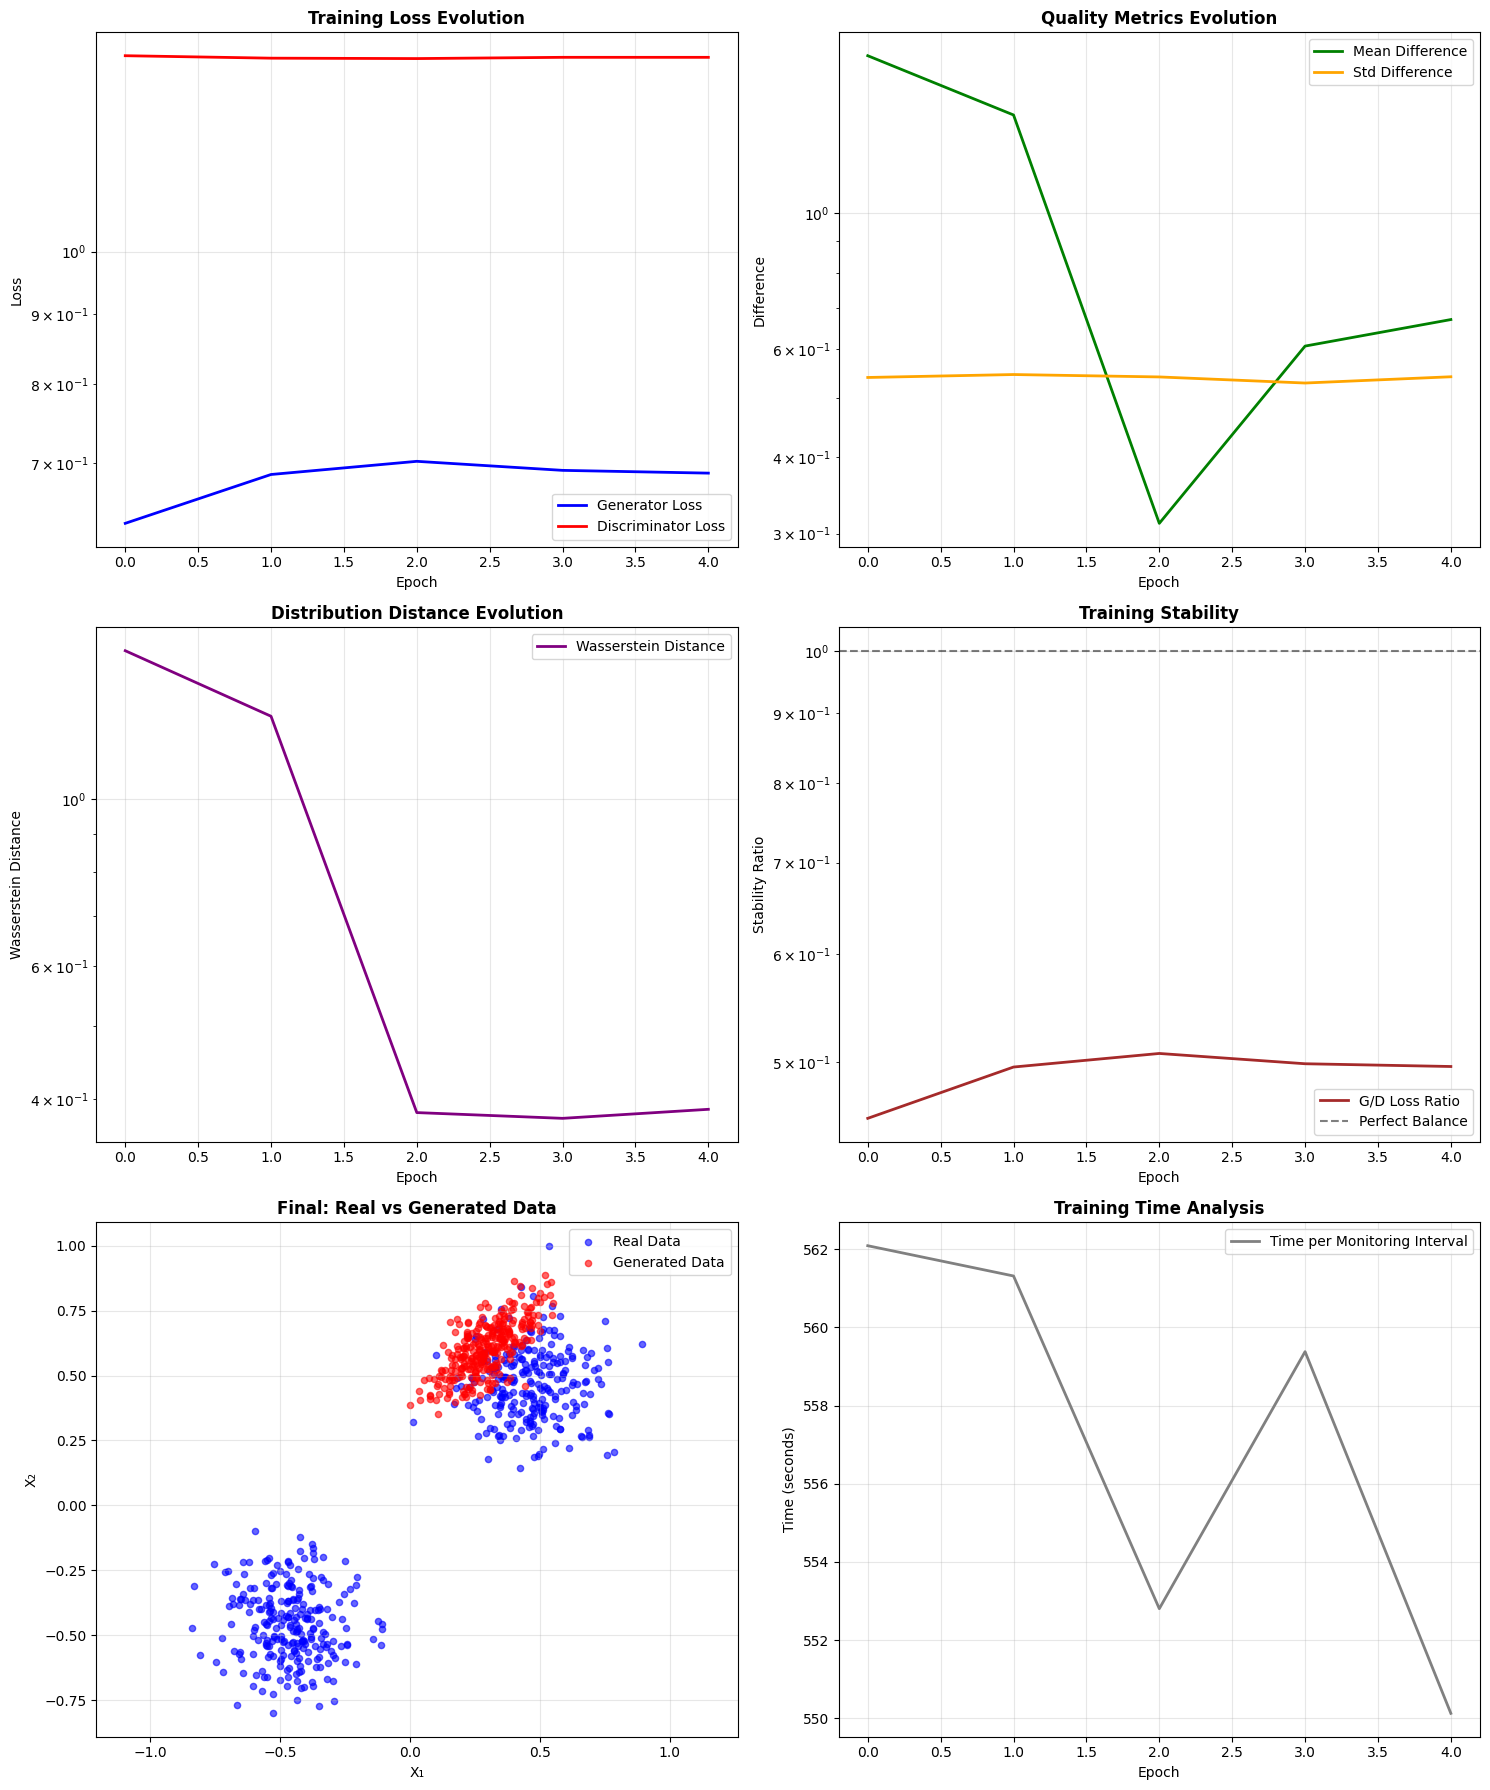


EXTENDED TRAINING ANALYSIS

Quality Improvement:
  Initial Mean Difference: 1.8087
  Final Mean Difference: 0.6708
  Improvement: 62.9%

Final Metrics:
  Generator Loss: 0.6887
  Discriminator Loss: 1.3870
  Stability Ratio: 0.4965
  Final Wasserstein Distance: 0.3874

Training Configuration:
  Total Epochs: 5 monitoring points over 4 epochs
  Architecture: Generator(92 params), Discriminator(32 params)
  Total Training Time: 2785.7s



In [ ]:
import matplotlib
matplotlib.use('Agg')  # or 'TkAgg' or 'Qt5Agg'
import matplotlib.pyplot as plt
%matplotlib inline

# Create comprehensive training dashboard
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

epochs = training_history['epochs']

# 1. Loss Evolution
ax1 = axes[0, 0]
ax1.plot(epochs, training_history['generator_losses'], label='Generator Loss', color='blue', linewidth=2)
ax1.plot(epochs, training_history['discriminator_losses'], label='Discriminator Loss', color='red', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Evolution', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. Quality Metrics Evolution
ax2 = axes[0, 1]
ax2.plot(epochs, training_history['mean_differences'], label='Mean Difference', color='green', linewidth=2)
ax2.plot(epochs, training_history['std_differences'], label='Std Difference', color='orange', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Difference')
ax2.set_title('Quality Metrics Evolution', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# 3. Wasserstein Distance
ax3 = axes[1, 0]
valid_wd = [wd for wd in training_history['wasserstein_distances'] if wd != float('inf')]
valid_epochs = epochs[:len(valid_wd)]
if valid_wd:
    ax3.plot(valid_epochs, valid_wd, label='Wasserstein Distance', color='purple', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Wasserstein Distance')
    ax3.set_title('Distribution Distance Evolution', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')

# 4. Stability Metric
ax4 = axes[1, 1]
ax4.plot(epochs, training_history['stability_metrics'], label='G/D Loss Ratio', color='brown', linewidth=2)
ax4.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect Balance')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Stability Ratio')
ax4.set_title('Training Stability', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

# 5. Final Generated vs Real Data
ax5 = axes[2, 0]
final_quality = trainer.compute_quality_metrics(real_data, n_samples=300)
generated_samples = final_quality['generated_samples']

ax5.scatter(real_data[:, 0], real_data[:, 1], alpha=0.6, s=20, color='blue', label='Real Data')
ax5.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.6, s=20, color='red', label='Generated Data')
ax5.set_xlabel('X₁')
ax5.set_ylabel('X₂')
ax5.set_title('Final: Real vs Generated Data', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.axis('equal')

# 6. Training Time Analysis
ax6 = axes[2, 1]
ax6.plot(epochs, training_history['training_times'], label='Time per Monitoring Interval', color='gray', linewidth=2)
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Time (seconds)')
ax6.set_title('Training Time Analysis', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
#plt.suptitle('Extended Quantum GAN Training Dashboard', fontsize=16, fontweight='bold', y=0.98)
plt.show()

# Print final analysis
print("\n" + "="*60)
print("EXTENDED TRAINING ANALYSIS")
print("="*60)

initial_mean_diff = training_history['mean_differences'][0]
final_mean_diff = training_history['mean_differences'][-1]
improvement = ((initial_mean_diff - final_mean_diff) / initial_mean_diff) * 100

print(f"\nQuality Improvement:")
print(f"  Initial Mean Difference: {initial_mean_diff:.4f}")
print(f"  Final Mean Difference: {final_mean_diff:.4f}")
print(f"  Improvement: {improvement:.1f}%")

print(f"\nFinal Metrics:")
print(f"  Generator Loss: {training_history['generator_losses'][-1]:.4f}")
print(f"  Discriminator Loss: {training_history['discriminator_losses'][-1]:.4f}")
print(f"  Stability Ratio: {training_history['stability_metrics'][-1]:.4f}")

if valid_wd:
    print(f"  Final Wasserstein Distance: {valid_wd[-1]:.4f}")

print(f"\nTraining Configuration:")
print(f"  Total Epochs: {len(epochs)} monitoring points over {max(epochs)} epochs")
print(f"  Architecture: Generator({len(generator.trainable_variables)} params), Discriminator({len(discriminator.trainable_variables)} params)")
print(f"  Total Training Time: {sum(training_history['training_times']):.1f}s")

# Convergence analysis
if len(training_history['mean_differences']) > 10:
    recent_improvement = training_history['mean_differences'][-5:]
    if max(recent_improvement) - min(recent_improvement) < 0.1:
        print(f"\n✓ Training appears to have converged (stable quality in last 5 measurements)")
    else:
        print(f"\n⚠ Training may benefit from additional epochs (quality still changing)")

print("\n" + "="*60)


## 6. Detailed Quality Assessment


Performing detailed quality assessment...

Final Quality Assessment (500 samples):
  Mean Difference: 0.6624
  Std Difference: 0.5431
  Wasserstein Distance: 0.3921

Quality Benchmarks:
  ✓ Good mean matching (< 1.0)
  ✓ Good variance matching (< 0.6)


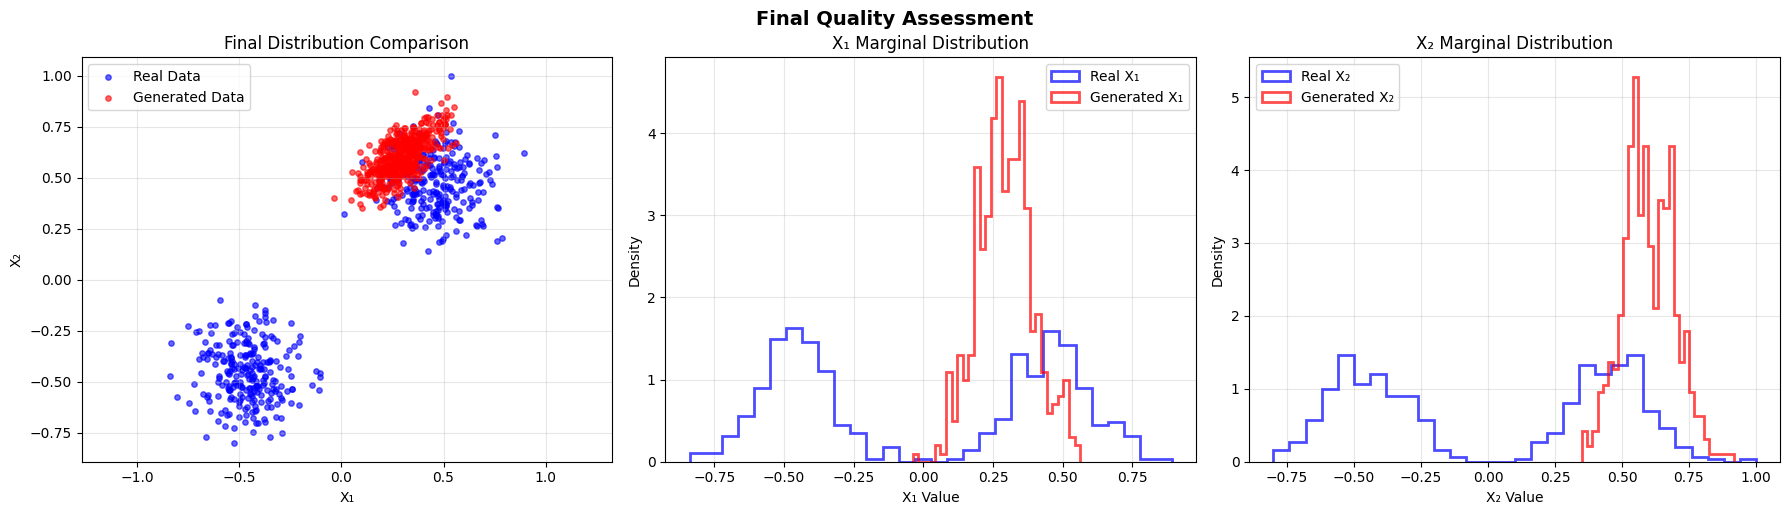

In [ ]:
# Comprehensive final evaluation
print("Performing detailed quality assessment...")

# Generate larger sample for final evaluation
final_evaluation = trainer.compute_quality_metrics(real_data, n_samples=500)

print(f"\nFinal Quality Assessment (500 samples):")
print(f"  Mean Difference: {final_evaluation['mean_difference']:.4f}")
print(f"  Std Difference: {final_evaluation['std_difference']:.4f}")
print(f"  Wasserstein Distance: {final_evaluation['wasserstein_distance']:.4f}")

# Quality benchmarks
print(f"\nQuality Benchmarks:")
if final_evaluation['mean_difference'] < 0.5:
    print(f"  ✓ Excellent mean matching (< 0.5)")
elif final_evaluation['mean_difference'] < 1.0:
    print(f"  ✓ Good mean matching (< 1.0)")
elif final_evaluation['mean_difference'] < 2.0:
    print(f"  ⚠ Fair mean matching (< 2.0)")
else:
    print(f"  ✗ Poor mean matching (≥ 2.0)")

if final_evaluation['std_difference'] < 0.3:
    print(f"  ✓ Excellent variance matching (< 0.3)")
elif final_evaluation['std_difference'] < 0.6:
    print(f"  ✓ Good variance matching (< 0.6)")
else:
    print(f"  ⚠ Poor variance matching (≥ 0.6)")

# Distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

generated_samples = final_evaluation['generated_samples']

# Scatter plot comparison
ax1 = axes[0]
ax1.scatter(real_data[:, 0], real_data[:, 1], alpha=0.6, s=15, color='blue', label='Real Data')
ax1.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.6, s=15, color='red', label='Generated Data')
ax1.set_xlabel('X₁')
ax1.set_ylabel('X₂')
ax1.set_title('Final Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# X1 marginal distribution
ax2 = axes[1]
ax2.hist(real_data[:, 0].numpy(), bins=30, alpha=0.7, density=True, color='blue', label='Real X₁', histtype='step', linewidth=2)
ax2.hist(generated_samples[:, 0], bins=30, alpha=0.7, density=True, color='red', label='Generated X₁', histtype='step', linewidth=2)
ax2.set_xlabel('X₁ Value')
ax2.set_ylabel('Density')
ax2.set_title('X₁ Marginal Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# X2 marginal distribution
ax3 = axes[2]
ax3.hist(real_data[:, 1].numpy(), bins=30, alpha=0.7, density=True, color='blue', label='Real X₂', histtype='step', linewidth=2)
ax3.hist(generated_samples[:, 1], bins=30, alpha=0.7, density=True, color='red', label='Generated X₂', histtype='step', linewidth=2)
ax3.set_xlabel('X₂ Value')
ax3.set_ylabel('Density')
ax3.set_title('X₂ Marginal Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Final Quality Assessment', fontsize=14, fontweight='bold', y=1.02)
plt.show()

